In [1]:
# Standard Imports
import os
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Silence tensforflow for the time being
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
"""
Construct input PDF replicas
"""

from ganpdfs.pdformat import XNodes
from ganpdfs.pdformat import InputPDFs

# Define Parameters
nf = 3
q_value = 1.7
pdf_name = "PN3_GLOBAL_NNPDF31_nnlo_as_0118_070219-001"

# Compute PDF replicas grid
xgrid = XNodes().build_xgrid()
pdf = InputPDFs(pdf_name, xgrid, q_value, nf).build_pdf()

pdf.shape

(81, 7, 70, 1)

In [3]:
import keras.backend as K
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from keras import Model
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import multiply
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint

In [4]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

# Input PDF Layer
class add_pdf(Layer):
    
    def __init__(self, pdf, trainable=True, **kwargs):
        i = np.random.randint(50)
        self.pdf = K.constant(pdf[i])
        self.trainable = trainable
        super(add_pdf, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return (None, self.pdf.shape[0], self.pdf.shape[1], self.pdf.shape[2])

    def call(self, model_input):
        res = model_input * self.pdf
        return res

In [5]:
# define the standalone critic model
def define_critic(in_shape=(7,70,1)):
    # weight constraint
    const = ClipConstraint(1)
    # define model
    model = Sequential()
    # downsample to 7x35
    model.add(Conv2D(64, (4,4), strides=(1,2), padding='same', kernel_constraint=const, input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 7x7
    model.add(Conv2D(64, (4,4), strides=(1,5), padding='same', kernel_constraint=const))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # scoring, linear activation
    model.add(Flatten())
    model.add(Dense(1))
    # compile model
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

# define the standalone generator model
def define_generator(latent_dim):
    # define model
    model = Sequential()
    n_nodes = 256 * 7 * 7
    # Define input
    g_input = Input(shape=latent_dim)
    g1l = Dense(n_nodes)(g_input)
    g1a = LeakyReLU(alpha=0.2)(g1l)
    g1r = Reshape((7, 7, 256))(g1a)
    # upsample to 7x35
    g2l = Conv2DTranspose(128, (4,4), strides=(1,5), padding='same')(g1r)
    g2b = BatchNormalization()(g2l)
    g2a = LeakyReLU(alpha=0.2)(g2b)
    # upsample to 7x70
    g3l = Conv2DTranspose(128, (4,4), strides=(1,2), padding='same')(g2a)
    g3b = BatchNormalization()(g3l)
    g3a = LeakyReLU(alpha=0.2)(g3b)
    # output 28x28x1
    g4l = Conv2D(1, (7,7), activation='tanh', padding='same')(g3a)
    g_output = add_pdf(pdf)(g4l)
    return Model(g_input, g_output, name="generator")

# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
    # make weights in the critic not trainable
    # critic.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the critic
    model.add(critic)
    # compile model
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

In [6]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels, -1 for 'real'
    y = -ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels with 1.0 for 'fake'
    y = ones((n_samples, 1))
    return X, y

In [7]:
def plot_generated_pdf(true_pdf, g_model, nth_epochs, latent_dim, nb_output):
    """This method plots the comparison of the true
    and generated PDF replicas at each iterations for
    given flavours.
    """

    # Generate random vector and use it to make a prediction
    # for the Generator after a given training
    generated_pdf, _ = generate_fake_samples(g_model, latent_dim, nb_output)

    # Initialize the figure as a 4x4 grid
    fig = plt.figure(constrained_layout=True)
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
    pl1 = fig.add_subplot(spec[0, 0])
    pl2 = fig.add_subplot(spec[0, 1])
    pl3 = fig.add_subplot(spec[1, 0])
    pl4 = fig.add_subplot(spec[1, 1])

    # Define list of flavours and grids
    fl = [0, 1, 3, 6]
    ls_pl = [pl1, pl2, pl3, pl4]

    for fl, pos in zip(fl, ls_pl):
        # Plot true replicas
        for true_rep in true_pdf:
            pos.plot(
                    xgrid,
                    true_rep[fl],
                    color="r",
                    label="true",
                    alpha=0.35
            )
        # Plot fake replicas
        for fake_rep in generated_pdf:
            pos.plot(
                    xgrid,
                    fake_rep[fl],
                    color="b",
                    label="fake",
                    alpha=0.35
            )
        # Plot in log scale
        pos.set_xscale("log")

    fig.suptitle("Samples at Iteration %d" % nth_epochs)
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [8]:
# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=5000, n_batch=64, n_critic=4, n_gens=3):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # lists for keeping track of loss
    c1_hist, c2_hist, g_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(n_steps):
        # update the critic more than the generator
        c1_tmp, c2_tmp = list(), list()
        # Set critic training to True
        c_model.trainable = True
        for _ in range(n_critic):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update critic model weights
            c_loss1 = c_model.train_on_batch(X_real, y_real)
            c1_tmp.append(c_loss1)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update critic model weights
            c_loss2 = c_model.train_on_batch(X_fake, y_fake)
            c2_tmp.append(c_loss2)
        # store critic loss
        c1_hist.append(mean(c1_tmp))
        c2_hist.append(mean(c2_tmp))
        # Set critic training to False
        c_model.trainable = False
        for _ in range(n_gens):
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = -ones((n_batch, 1))
            # update the generator via the critic's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            g_hist.append(g_loss)
        # summarize loss on this batch
        if (i+1) % 1000 == 0:
            # print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
            plot_generated_pdf(dataset, g_model, i+1, latent_dim, dataset.shape[0])

In [9]:
# size of the latent space
latent_dim = 100
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)

In [10]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 35, 128)        524416    
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 35, 128)        512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 35, 128)        0 

In [11]:
critic.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7, 35, 64)         1088      
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 35, 64)         256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 7, 35, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          65600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [12]:
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Model)            (None, 7, 70, 1)          2060929   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 70337     
Total params: 2,131,266
Trainable params: 2,130,498
Non-trainable params: 768
_________________________________________________________________


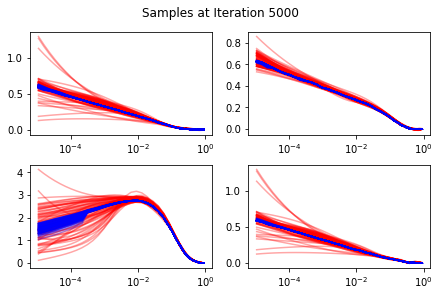

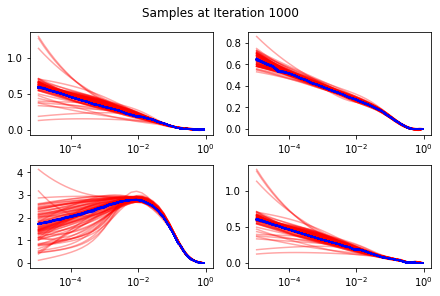

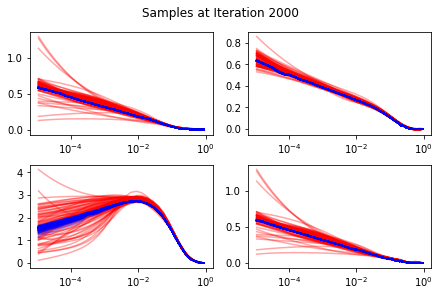

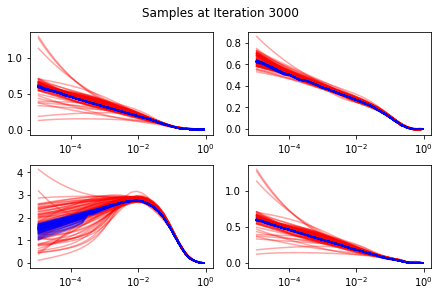

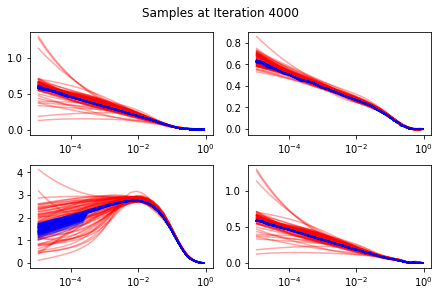

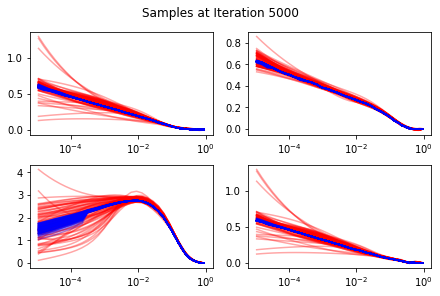

In [13]:
# train model
train(generator, critic, gan_model, pdf, latent_dim)